### FLiBe Simple

In [77]:
import openmc
import os, sys
from pathlib import Path
import numpy as np

# Import helper functions
sys.path.insert(0, f"{Path.cwd()}/helper")
from utilities import *

### Materials
FLiBe density is 1.94 g/cm$^3$ with 7.5% Li-6 enrichment. In the FLiBe, molar ratio of 2 LiF per BeF$_2$. The system is a volume of 342 m$^3$ at 900 K. We increase tons of U in the system, subtracting FLiBe, from 0 to 50 metric tons (MTU).

> [$\S$2.4] In this work, we investigate what happens when fertile species (U-238 or Th-232) are introduced to the FLiBe LIB in amounts ranging from 5 to 50 metric tons, corresponding to a maximum molar percentage of 1.81% and 1.84% for UF4 and ThF4 respectively, assuming a blanket volume of 342 m$^3$.
>
> [$\S$3.1] The total volume of FLiBe in the model is 342 m$^3$, with no additional volume added to account for FLiBe in other systems like pumps or heat exchangers. This results in a fertile mass loading of $2.92\times10^{−2}$ g cm$^{−3}$ metric ton of fertile material. For this study, examining a range of 5 to 50 metric tons of fertile material, this corresponds to a fertile mass density range of 0.146-1.46 g cm$^{−3}$.

In [96]:
""" USER SPECIFICATIONS
Nominal values used by Emma and Patrick + reasons
  DENSITY_FLIBE : float : 1.94 [g/cc] : used by Ball 25
  DENSITY_UF4   : float : 6.70 [g/cc] : used by Ball 25
  ENRICH_LI : float : 7.5 [wt%] : used by Ball 25 / 20 wt% used by Alex
  ENRICH_U : float : 0.7204 [wt%] : natural uranium from PNNL-15870 
  TEMP_K : float : 900 [K]
  VOL_CC : float : 342,000,000 [cc = 342 m3]
  MASS_U_LIST : list of floats : 0, 0.1, 1, 2.5, 5, 10, 20, 30, 40, 50 [metric tons U]
"""
DENSITY_FLIBE = 1.94 # g/cm3
DENSITY_UF4 = 6.7 # g/cm3
ENRICH_LI = 7.5 # 7.5 # wt%
ENRICH_U  = 0.7204 # wt% 
TEMP_K = 900 # K
VOL_CC = 342 * 1e6 # cm3
MASS_U_LIST = [0, 0.0096, 0.1, 0.2, 0.5, 1, 2.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # metric tons uranium (MTU)

In [97]:

""" MATERIALS """
# FLiBe
flibe = openmc.Material()
flibe.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=ENRICH_LI)
flibe.set_density('g/cm3', DENSITY_FLIBE) 
flibe.volume = VOL_CC
print(flibe.get_mass('U238'))
# Uranium tetrafluoride -- assumed to dissolve in FLiBe --ppark 2025-07-04
uf4 = openmc.Material()
uf4.add_elements_from_formula('UF4','ao',ENRICH_U) # 'ao' here refers to 1:4 atomic ratio of U:F in UF4!!!
uf4.set_density('g/cm3', DENSITY_UF4) 

# Calculate volume ratios of UF4 and FLiBe, ensure they add up to 1
mix_list = []
for mtu in MASS_U_LIST:
    print('mtu', mtu)
    vf_flibe, vf_uf4 = calc_mix_vol_fracs(mtu, volume=VOL_CC, density_flibe=DENSITY_FLIBE, displace=True) # './helper/utilities.py'
    mix = openmc.Material.mix_materials([flibe, uf4], [vf_flibe, vf_uf4], 'vo') # fractions in 'mix_materials' MUST add up to 1
    mix.name, mix.volume, mix.temperature = f"FLiBe + {mtu:.1f} MTU", VOL_CC, TEMP_K
    uf4.volume = vf_uf4 * VOL_CC
    print(mix.get_nuclide_atom_densities())
    print(mix.get_mass_density)
    mix_list.append(mix)

materials = openmc.Materials(mix_list)

0.0
mtu 0
{'F19': 0.04726838035117131, 'Li6': 0.002042024821229901, 'Li7': 0.021592165354355753, 'Be9': 0.011817095087792828, 'U234': 0.0, 'U235': 0.0, 'U238': 0.0, 'U236': 0.0}
<bound method Material.get_mass_density of Material
	ID             =	565
	Name           =	FLiBe + 0.0 MTU
	Temperature    =	900
	Density        =	1.94 [g/cm3]
	Volume         =	342000000.0 [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	F19            =	0.5714285714285714 [ao]
	Li6            =	0.02468608650747161 [ao]
	Li7            =	0.2610281992068141 [ao]
	Be9            =	0.14285714285714285 [ao]
	U234           =	0.0          [ao]
	U235           =	0.0          [ao]
	U238           =	0.0          [ao]
	U236           =	0.0          [ao]
>
mtu 0.0096
{'F19': 0.04726840316261043, 'Li6': 0.0020420135346486145, 'Li7': 0.021592046011178877, 'Be9': 0.011817029772913747, 'U234': 4.630924478058689e-12, 'U235': 5.181082504744147e-10, 'U238': 7.04926264997473e-08, 'U236': 2.3731846428567005e-12}

In [88]:
# Get various specs for double-checking
print(uf4.get_nuclide_densities())
print(uf4.get_nuclide_atom_densities('U238'))
print(f"Mix with {MASS_U_LIST[-1]} MTU")
print(f"Mix density: {mix_list[-1].get_mass_density():.6f}")
print(f"U-238 number density: {mix_list[-1].get_nuclide_atom_densities('U238')}")
print(f"Li-6 number density: {mix_list[-1].get_nuclide_atom_densities('Li6')}")

{'U234': NuclideTuple(name='U234', percent=5.4e-05, percent_type='ao'), 'U235': NuclideTuple(name='U235', percent=0.007204, percent_type='ao'), 'U238': NuclideTuple(name='U238', percent=0.992742, percent_type='ao')}
{'U238': 0.047972346247271286}
Mix with 50 MTU
Mix density: 2.070352
U-238 number density: {'U238': 0.00036440966733972905}
Li-6 number density: {'Li6': 0.002026513101582747}


In [89]:
""" CROSS SECTIONS 
Temporary solution for finding xs files between WSL and Ubuntu on Computing Cluster without editing PATH --ppark 2025-06-28 
"""
xs_path_ubuntu = '/opt/openmc_data/endfb-viii.0-hdf5/cross_sections.xml'
xs_path_wsl   = '/mnt/c/openmc/data/endfb-viii.0-hdf5/cross_sections.xml'
if os.path.isfile(xs_path_ubuntu):
    materials.cross_sections = xs_path_ubuntu # use this on Zotacs --ppark
elif os.path.isfile(xs_path_wsl):
    materials.cross_sections = xs_path_wsl
else:
    print(f"Error finding cross section XML!")
    # sys.exit(2)

#### Geometry
For our simple case suppose we make a 1 m$^3$ cube with reflective surfaces of homogeneous FLiBe. 

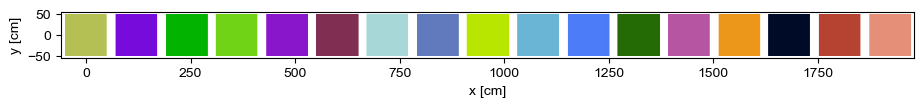

In [90]:
""" GEOMETRY """
cells, pitch, half_box = [], 120, 50 # +/- 50 cm bounds
box_centers = [pitch * i for i in range(len(MASS_U_LIST))] # used in Sources

for i, material in enumerate(mix_list):
    x_min = openmc.XPlane(x0= -half_box + box_centers[i], boundary_type='reflective')
    x_max = openmc.XPlane(x0=  half_box + box_centers[i], boundary_type='reflective')
    y_min, y_max = openmc.YPlane(-50, boundary_type='reflective'), openmc.YPlane( 50, boundary_type='reflective')
    z_min, z_max = openmc.ZPlane(-50, boundary_type='reflective'), openmc.ZPlane( 50, boundary_type='reflective')
    region = +x_min & -x_max & +y_min & -y_max & +z_min & -z_max
    
    cell = openmc.Cell(fill=material, region=region)
    cell.name = f"mix-{i+1}"
    cells.append(cell)

root_univ = openmc.Universe(cells=cells) # Create root universe with all material cells
root_univ.plot(width=(pitch * len(MASS_U_LIST), 110), origin=(pitch * (len(MASS_U_LIST) - 1) / 2, 0.0, 0.0)) # Visualize
geometry = openmc.Geometry(root_univ) # Set geometry

#### Settings
Here we define the other settings for our problem. 

In [91]:
""" TALLIES """
tallies = openmc.Tallies() # initialize

# Filters
cell_filter = openmc.CellFilter(cells)

E_bin_edges = logspace_per_decade(1e-5, 20e6, 100) # './helpers/utilities.py'
energy_filter = openmc.EnergyFilter(E_bin_edges)
# energy_filter = openmc.EnergyFilter([0., 0.625, 20.0e6])
# --Default thermal, intermediate, fast energy cutoffs in MCNP
# energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')
# --These have extra bins in key energy ranges. A full list of energy structures is available here: --ppark 2025-06-27
#   https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420
filters = [energy_filter, cell_filter]

# Flux tally 
flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux'] # specific names required
flux_tally.filters = filters

# Uranium reaction rates
U_tally = openmc.Tally(name='uranium rxn rates')
U_tally.scores = ['(n,gamma)','fission', 'elastic'] # specific names required
U_tally.nuclides = ['U238', 'U235']
U_tally.filters = filters

# Lithium reaction rates
Li_tally = openmc.Tally(name='lithium rxn rates')
Li_tally.scores = ['(n,gamma)','(n,Xt)', 'elastic'] # specific names required
Li_tally.nuclides = ['Li6', 'Li7']
Li_tally.filters = filters

# Fluorine reaction rates
F_tally = openmc.Tally(name='fluorine rxn rates')
F_tally.scores = ['(n,gamma)', 'elastic'] # specific names required
F_tally.nuclides = ['F19']
F_tally.filters = filters

# Beryllium reaction rates
Be_tally = openmc.Tally(name='beryllium rxn rates')
Be_tally.scores = ['(n,gamma)','(n,2n)', 'elastic'] # specific names required
Be_tally.nuclides = ['Be9']
Be_tally.filters = filters

tallies.extend([flux_tally, U_tally, Li_tally, F_tally, Be_tally])
# tallies.export_to_xml("./xml/tallies.xml") --don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

In [92]:
"""First Wall Effects"""
sp = openmc.StatePoint(f'./model_FirstWallTest_7_14/statepoint.100.h5')  
out_tally = sp.get_tally(name='outgoing_spectrum')

energy_bins = out_tally.filters[1].bins
energy_bins = np.array(energy_bins)  # shape (N, 2)

energy_midpoints = 0.5 * (energy_bins[:, 0] + energy_bins[:, 1])

current_spectrum = out_tally.get_values(scores=['current']).flatten()

total_current = current_spectrum.sum()
probabilities = current_spectrum / total_current


In [94]:
""" SETTINGS """
settings = openmc.Settings()

""" Source
Isotropic 14.07 MeV point source at center of each cube
"""
energies = energy_midpoints.tolist()
weights = probabilities.tolist()
source = []
for p in box_centers:
    src = openmc.IndependentSource()
    src.space  = openmc.stats.Point((p,0,0))
    src.angle  = openmc.stats.Isotropic()
    src.energy = openmc.stats.Discrete(energies, weights)
    source.append(src)
settings.source = source

""" Run type """
settings.run_mode = 'fixed source'
settings.particles = len(MASS_U_LIST) * int(1e3)  #  
settings.batches = 100

# settings.export_to_xml("./xml/settings.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

#### Run OpenMC
Don't run the `FLiBe-Plots.ipynb` if you plan on running OpenMC. Else you will get:
``` 
ERROR: Failed to open HDF5 file with mode ‘w’: summary.h5 
```
If you do, close all opened scripts, shut down all kernels, and then restart them.

In [95]:
model = openmc.model.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./model_Li6-7.5wt_7_14/")  # _Li6-20wt
results_NSlow = model.run(cwd="./model_Li6-7.5wt_7_14/")  # _Li6-20wt

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################